## SF fire incidents data analysis and modeling with Spark

In [2]:
from csv import reader
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from ggplot import *
from folium import plugins
import warnings
import os
import itertools

In [3]:
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_date, unix_timestamp, year, month, hour, to_timestamp, udf
from pyspark.sql.functions import concat, col, lit, udf, split
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("fire analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Load fire data from January 2003 to May 2018
df_fire = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Fire_Department_Calls_for_Service.csv")
df_fire.createOrReplaceTempView("sf_fire")

In [6]:
df_fire.printSchema()

root
-- Call Number: string (nullable = true)
-- Unit ID: string (nullable = true)
-- Incident Number: string (nullable = true)
-- Call Type: string (nullable = true)
-- Call Date: string (nullable = true)
-- Watch Date: string (nullable = true)
-- Received DtTm: string (nullable = true)
-- Entry DtTm: string (nullable = true)
-- Dispatch DtTm: string (nullable = true)
-- Response DtTm: string (nullable = true)
-- On Scene DtTm: string (nullable = true)
-- Transport DtTm: string (nullable = true)
-- Hospital DtTm: string (nullable = true)
-- Call Final Disposition: string (nullable = true)
-- Available DtTm: string (nullable = true)
-- Address: string (nullable = true)
-- City: string (nullable = true)
-- Zipcode of Incident: string (nullable = true)
-- Battalion: string (nullable = true)
-- Station Area: string (nullable = true)
-- Box: string (nullable = true)
-- Original Priority: string (nullable = true)
-- Priority: string (nullable = true)
-- Final Priority: string (nullable = true)
-- ALS Unit: string (nullable = true)
-- Call Type Group: string (nullable = true)
-- Number of Alarms: string (nullable = true)
-- Unit Type: string (nullable = true)
-- Unit sequence in call dispatch: string (nullable = true)
-- Fire Prevention District: string (nullable = true)
-- Supervisor District: string (nullable = true)
-- Neighborhooods - Analysis Boundaries: string (nullable = true)
-- Location: string (nullable = true)
-- RowID: string (nullable = true)

In [7]:
# Data size
df_fire.count()

Out[ 6 ]: 4854455

In [8]:
df_fire.show(30)

+-----------+-------+---------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+--------------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+--------------+
Call Number|Unit ID|Incident Number| Call Type| Call Date|Watch Date| Received DtTm| Entry DtTm| Dispatch DtTm| Response DtTm| On Scene DtTm| Transport DtTm| Hospital DtTm|Call Final Disposition| Available DtTm| Address|City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|Number of Alarms| Unit Type|Unit sequence in call dispatch|Fire Prevention District|Supervisor District|Neighborhooods - Analysis Boundaries| Location| RowID|
+-----------+-------+---------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+--------------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+--------------+
 001030101| E18| 00306091| Medical Incident|04/12/2000|04/12/2000|04/12/2000 09:00:...|04/12/2000 09:01:...|04/12/2000 09:02:...| null| null| null| null| Other| null|2000 Block of 37T...| SF| 94116| B08| 18|0757| 3| 3| 3| false| null| 1| ENGINE| 1| 8| 4| Sunset/Parkside|(37.7487247711275...| 001030101-E18|
 001030104| M14| 00030612| Medical Incident|04/12/2000|04/12/2000|04/12/2000 09:09:...|04/12/2000 09:10:...|04/12/2000 09:10:...|04/12/2000 09:12:...|04/12/2000 09:19:...|04/12/2000 09:43:...|04/12/2000 10:03:...| Other|04/12/2000 10:23:...|1700 Block of 43R...| SF| 94122| B08| 23|7651| 3| 3| 3| true| null| 1| MEDIC| 2| 8| 4| Sunset/Parkside|(37.7540326780595...| 001030104-M14|
 001030106| M36| 00030614| Medical Incident|04/12/2000|04/12/2000|04/12/2000 09:09:...|04/12/2000 09:10:...|04/12/2000 09:11:...| null|04/12/2000 09:14:...|04/12/2000 09:59:...|04/12/2000 10:10:...| Other|04/12/2000 10:43:...| 0 Block of FELL ST| SF| 94102| B02| 36|3111| 3| 3| 3| false| null| 1| MEDIC| 1| 2| 6| Tenderloin|(37.7764405100838...| 001030106-M36|
 001030107| E01| 00030615| Alarms|04/12/2000|04/12/2000|04/12/2000 09:13:...|04/12/2000 09:13:...|04/12/2000 09:14:...|04/12/2000 09:15:...|04/12/2000 09:20:...| null| null| Other|04/12/2000 09:24:...|100 Block of JONE...| SF| 94102| B03| 01|1456| 3| 3| 3| false| null| 1| ENGINE| 3| 3| 6| Tenderloin|(37.7825474000421...| 001030107-E01|
 001030108| RS1| 00030616| Medical Incident|04/12/2000|04/12/2000|04/12/2000 09:14:...|04/12/2000 09:16:...|04/12/2000 09:16:...|04/12/2000 09:18:...|04/12/2000 09:20:...| null| null| Other|04/12/2000 09:20:...|700 Block of MARK...| SF| 94108| B03| 01|1322| 3| 3| 3| false| null| 1| RESCUE SQUAD| 2| 1| 3| Financial Distric...|(37.7863072236365...| 001030108-RS1|
 001030112| T03| 00030620|Citizen Assist / ...|04/12/2000|04/12/2000|04/12/2000 09:24:...|04/12/2000 09:24:...|04/12/2000 09:25:...|04/12/2000 09:27:...|04/12/2000 09:30:...| null| null| Other|04/12/2000 09:44:...|800 Block of SUTT...| SF| 94109| B01| 03|1463| 3| 3| 3| false| null| 1| TRUCK| 1| 1| 3| Nob Hill|(37.7884388430214...| 001030112-T03|
 001030116| E38| 00030624| Electrical Hazard|04/12/2000|04/12/2000|04/12/2000 09:25:...|04/12/2000 09:28:...|04/12/2000 09:28:...|04/12/2000 09:29:...|04/12/2000 09:31:...| null| null| Other|04/12/2000 09:39:...|C

In [9]:
# Data processing
def trim(string):
    return string.strip('()')
trim = udf(trim)
df = df_fire.withColumn('Location', trim(df_fire['Location']))

In [10]:
split_col = split(df['Location'], ',')
df = df.withColumn('Y', split_col.getItem(0))
df = df.withColumn('X', split_col.getItem(1))

In [11]:
df = (df.withColumn('X',df['X'].cast('float'))
        .withColumn('Y',df['Y'].cast('float')))

In [12]:
# Create a columns with datetime formats
df = (df.withColumn("Received DtTm", unix_timestamp("Received DtTm", "MM/dd/yyyy hh:mm:ss a").cast('timestamp'))
        .withColumn("Year", year(col("Received DtTm")))
        .withColumn("Month", month(col("Received DtTm"))).withColumn("hour", hour(col("Received DtTm"))))

#### OLAP: 
##### 1. The number of incidents for different call type.

In [14]:
df = df.filter(df['Call Type'] != 'Medical Incident')
q1_result = df.groupBy('Call Type').count().orderBy('count', ascending=False)
q1_result.show()

+--------------------+------+
 Call Type| count|
+--------------------+------+
 Structure Fire|631058|
 Alarms|521094|
 Traffic Collision|199176|
 Other| 77495|
Citizen Assist / ...| 72942|
 Outside Fire| 57596|
 Vehicle Fire| 23307|
 Water Rescue| 23162|
Gas Leak (Natural...| 18519|
 Electrical Hazard| 13709|
Elevator / Escala...| 12810|
Odor (Strange / U...| 12505|
Smoke Investigati...| 10788|
 Fuel Spill| 5613|
 HazMat| 3943|
Industrial Accidents| 2850|
 Explosion| 2591|
 Aircraft Emergency| 1511|
 Assist Police| 1342|
Train / Rail Inci...| 1278|
+--------------------+------+
only showing top 20 rows

In [15]:
# Show the number of incidents for different fire emergency call type
q1 = q1_result.toPandas()
print (q1)

Call Type count
0 Structure Fire 631058
1 Alarms 521094
2 Traffic Collision 199176
3 Other 77495
4 Citizen Assist / Service Call 72942
5 Outside Fire 57596
6 Vehicle Fire 23307
7 Water Rescue 23162
8 Gas Leak (Natural and LP Gases) 18519
9 Electrical Hazard 13709
10 Elevator / Escalator Rescue 12810
11 Odor (Strange / Unknown) 12505
12 Smoke Investigation (Outside) 10788
13 Fuel Spill 5613
14 HazMat 3943
15 Industrial Accidents 2850
16 Explosion 2591
17 Aircraft Emergency 1511
18 Assist Police 1342
19 Train / Rail Incident 1278
20 High Angle Rescue 1172
21 Watercraft in Distress 913
22 Extrication / Entrapped (Machinery, Vehicle) 714
23 Oil Spill 516
24 Confined Space / Structure Collapse 515
25 Mutual Aid / Assist Outside Agency 471
26 Marine Fire 371
27 Suspicious Package 328
28 Administrative 269
29 Train / Rail Fire 23
30 Lightning Strike (Investigation) 9

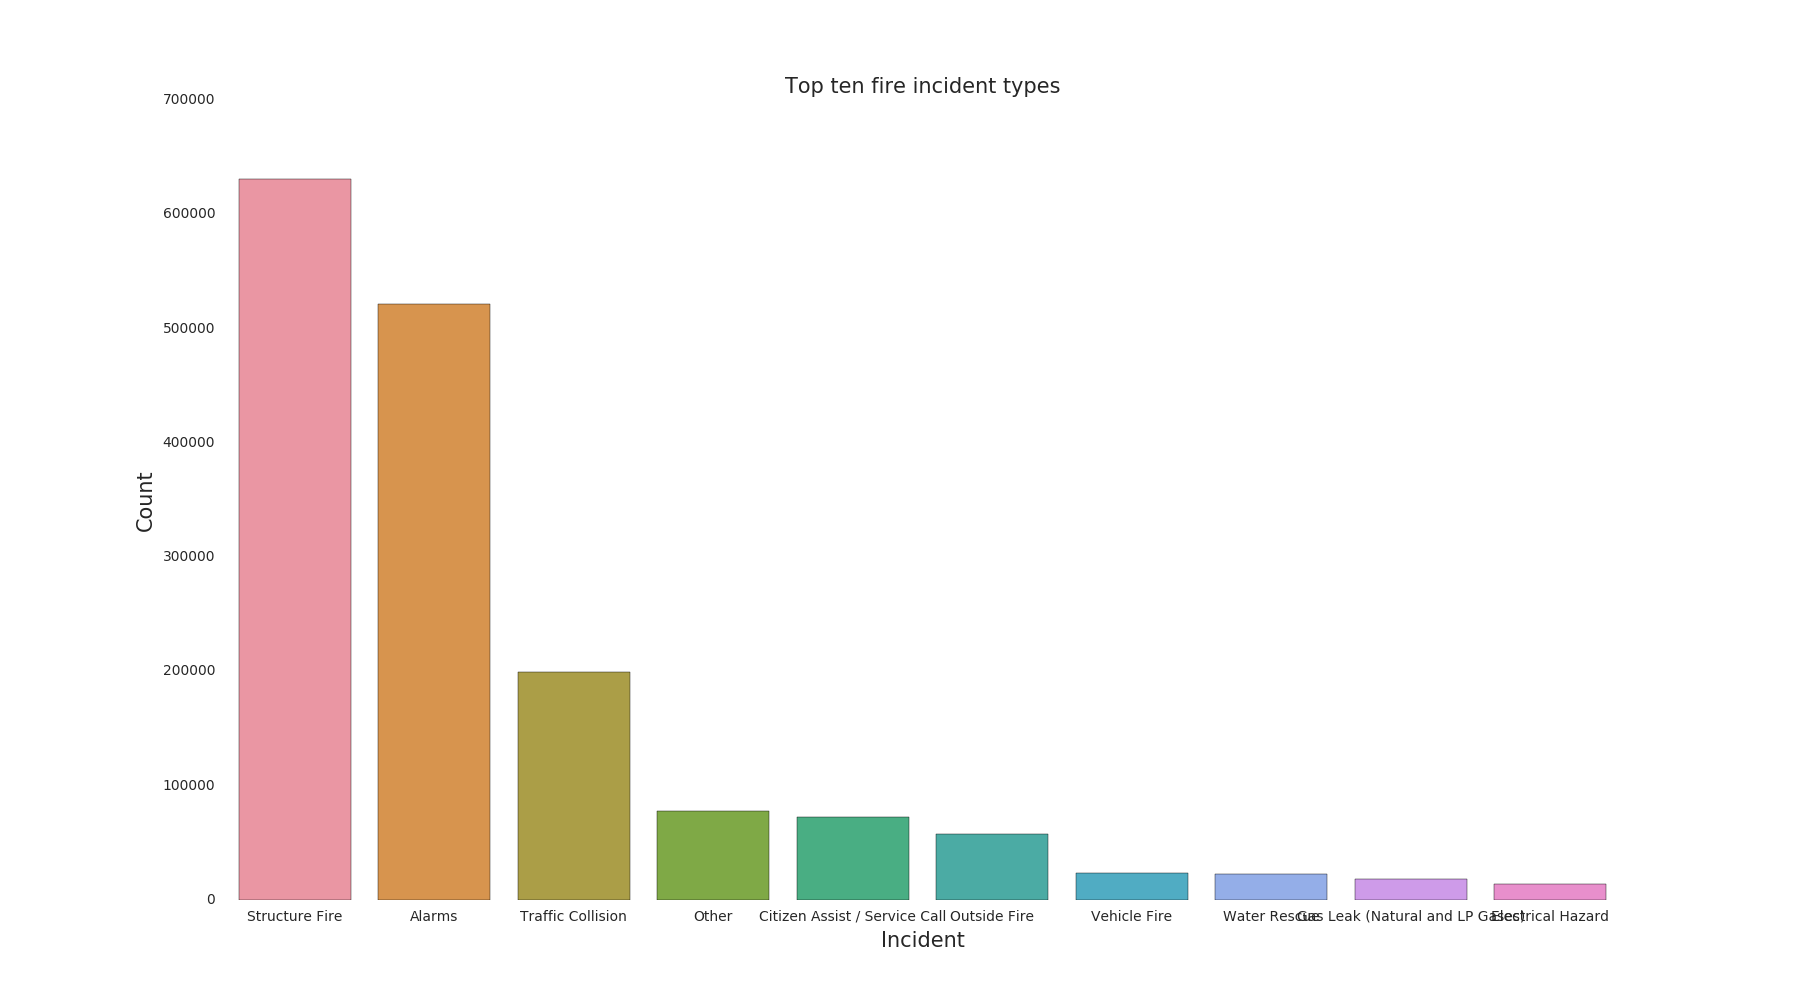

In [16]:
# Visualize top ten fire department incidents in San Francisco
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='Call Type', y='count', data=q1.loc[:9, :], ax=ax)
ax.set_title('Top ten fire incident types', fontsize=15)
ax.set_xlabel('Incident', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
display(fig)

##### 2. Counts the number of incidents for different neighborhooods.

In [18]:
q2_result = df.groupBy('Neighborhooods - Analysis Boundaries').count().orderBy('count', ascending=False)
q2_result.show()

+------------------------------------+------+
Neighborhooods - Analysis Boundaries| count|
+------------------------------------+------+
 Tenderloin|155123|
 Financial Distric...|148470|
 Mission|139231|
 South of Market|122425|
 Bayview Hunters P...| 95419|
 Western Addition| 64513|
 Nob Hill| 61958|
 Sunset/Parkside| 56841|
 Pacific Heights| 47646|
 Hayes Valley| 44628|
 Outer Richmond| 44027|
 Marina| 42271|
 Chinatown| 41145|
 Castro/Upper Market| 40705|
 West of Twin Peaks| 40360|
 North Beach| 39750|
 Potrero Hill| 37058|
 Bernal Heights| 34647|
 Russian Hill| 34193|
 Inner Sunset| 31692|
+------------------------------------+------+
only showing top 20 rows

In [19]:
# The number of fire incidents for different neighborhoood
q2 = q2_result.toPandas()
print(q2)

Neighborhooods - Analysis Boundaries count
0 Tenderloin 155123
1 Financial District/South Beach 148470
2 Mission 139231
3 South of Market 122425
4 Bayview Hunters Point 95419
5 Western Addition 64513
6 Nob Hill 61958
7 Sunset/Parkside 56841
8 Pacific Heights 47646
9 Hayes Valley 44628
10 Outer Richmond 44027
11 Marina 42271
12 Chinatown 41145
13 Castro/Upper Market 40705
14 West of Twin Peaks 40360
15 North Beach 39750
16 Potrero Hill 37058
17 Bernal Heights 34647
18 Russian Hill 34193
19 Inner Sunset 31692
20 Lakeshore 29960
21 Excelsior 28443
22 Haight Ashbury 27573
23 Inner Richmond 25334
24 Oceanview/Merced/Ingleside 24612
25 Outer Mission 24275
26 Mission Bay 24118
27 Lone Mountain/USF 23539
28 Noe Valley 23186
29 Presidio Heights 19446
30 Visitacion Valley 18129
31 Treasure Island 15203
32 Portola 14823
33 None 13544
34 Japantown 12901
35 Golden Gate Park 11339
36 Twin Peaks 10893
37 Presidio 9865
38 Glen Park 9022
39 Seacliff 4217
40 McLaren Park 3117
41 Lincoln Park 2949

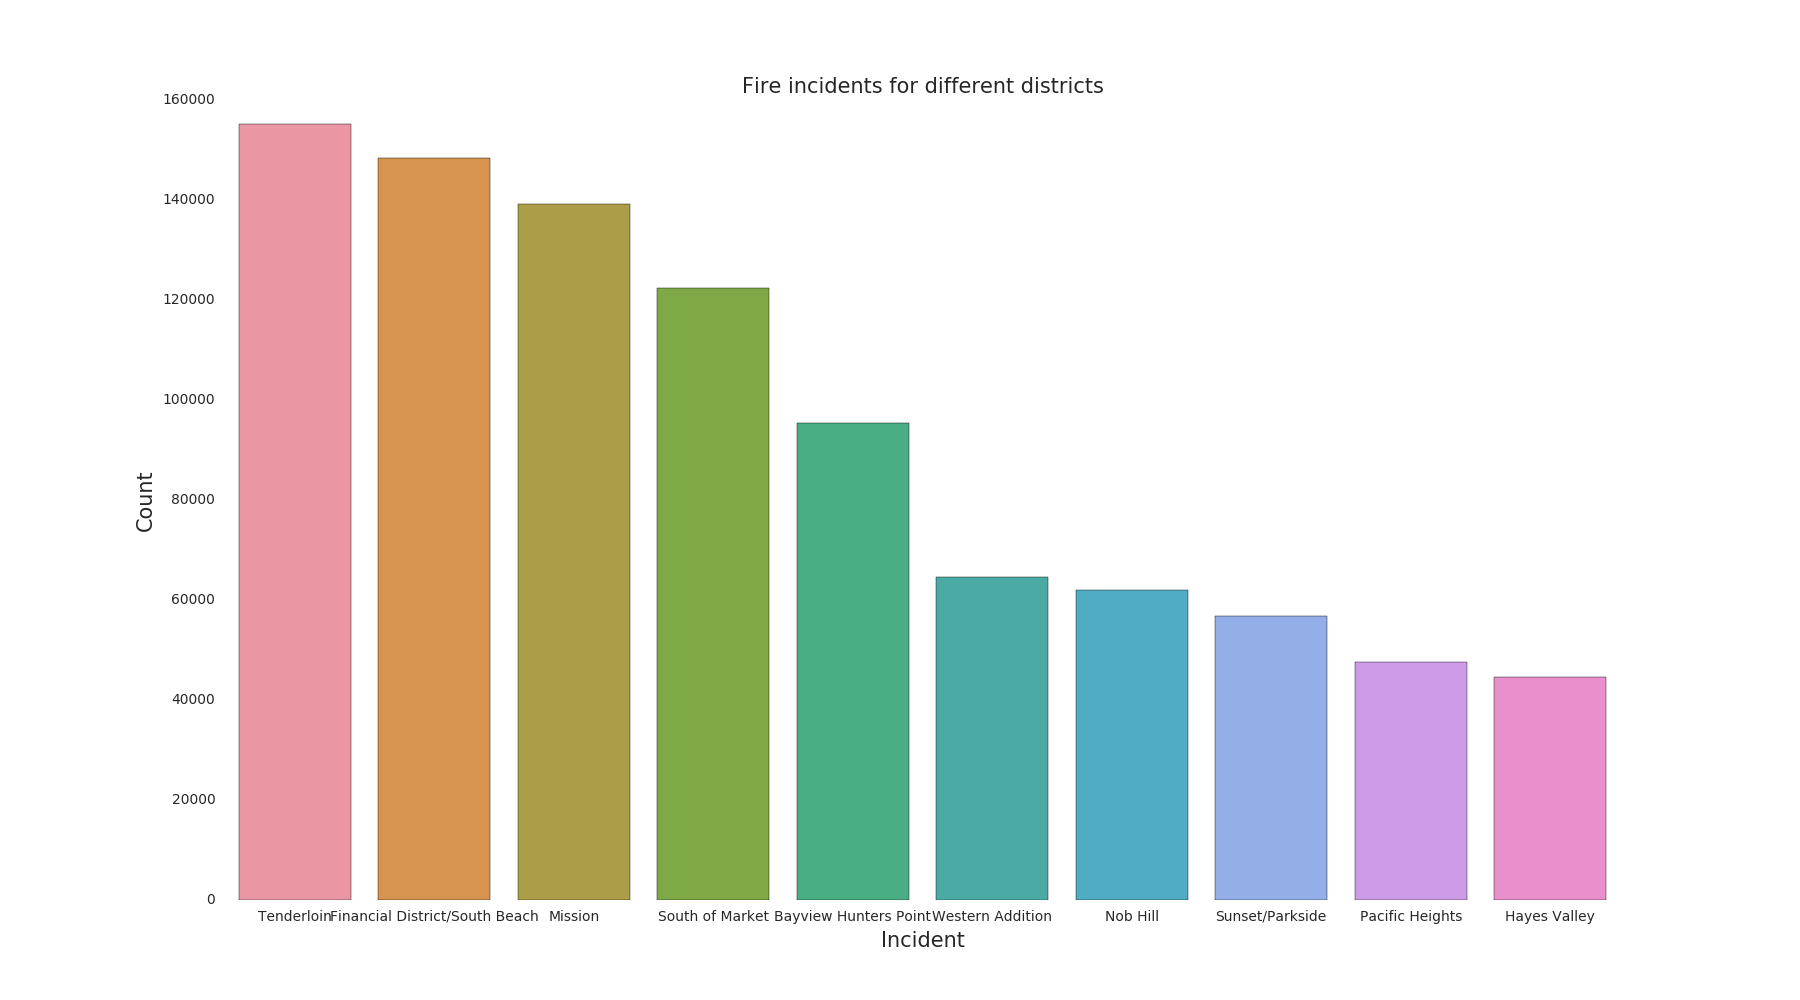

In [20]:
# Visualize fire incidents for different neighborhoood
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='Neighborhooods - Analysis Boundaries', y='count', data=q2.loc[:9, :], ax=ax)
ax.set_title('Fire incidents for different districts', fontsize=15)
ax.set_xlabel('Incident', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
display(fig)

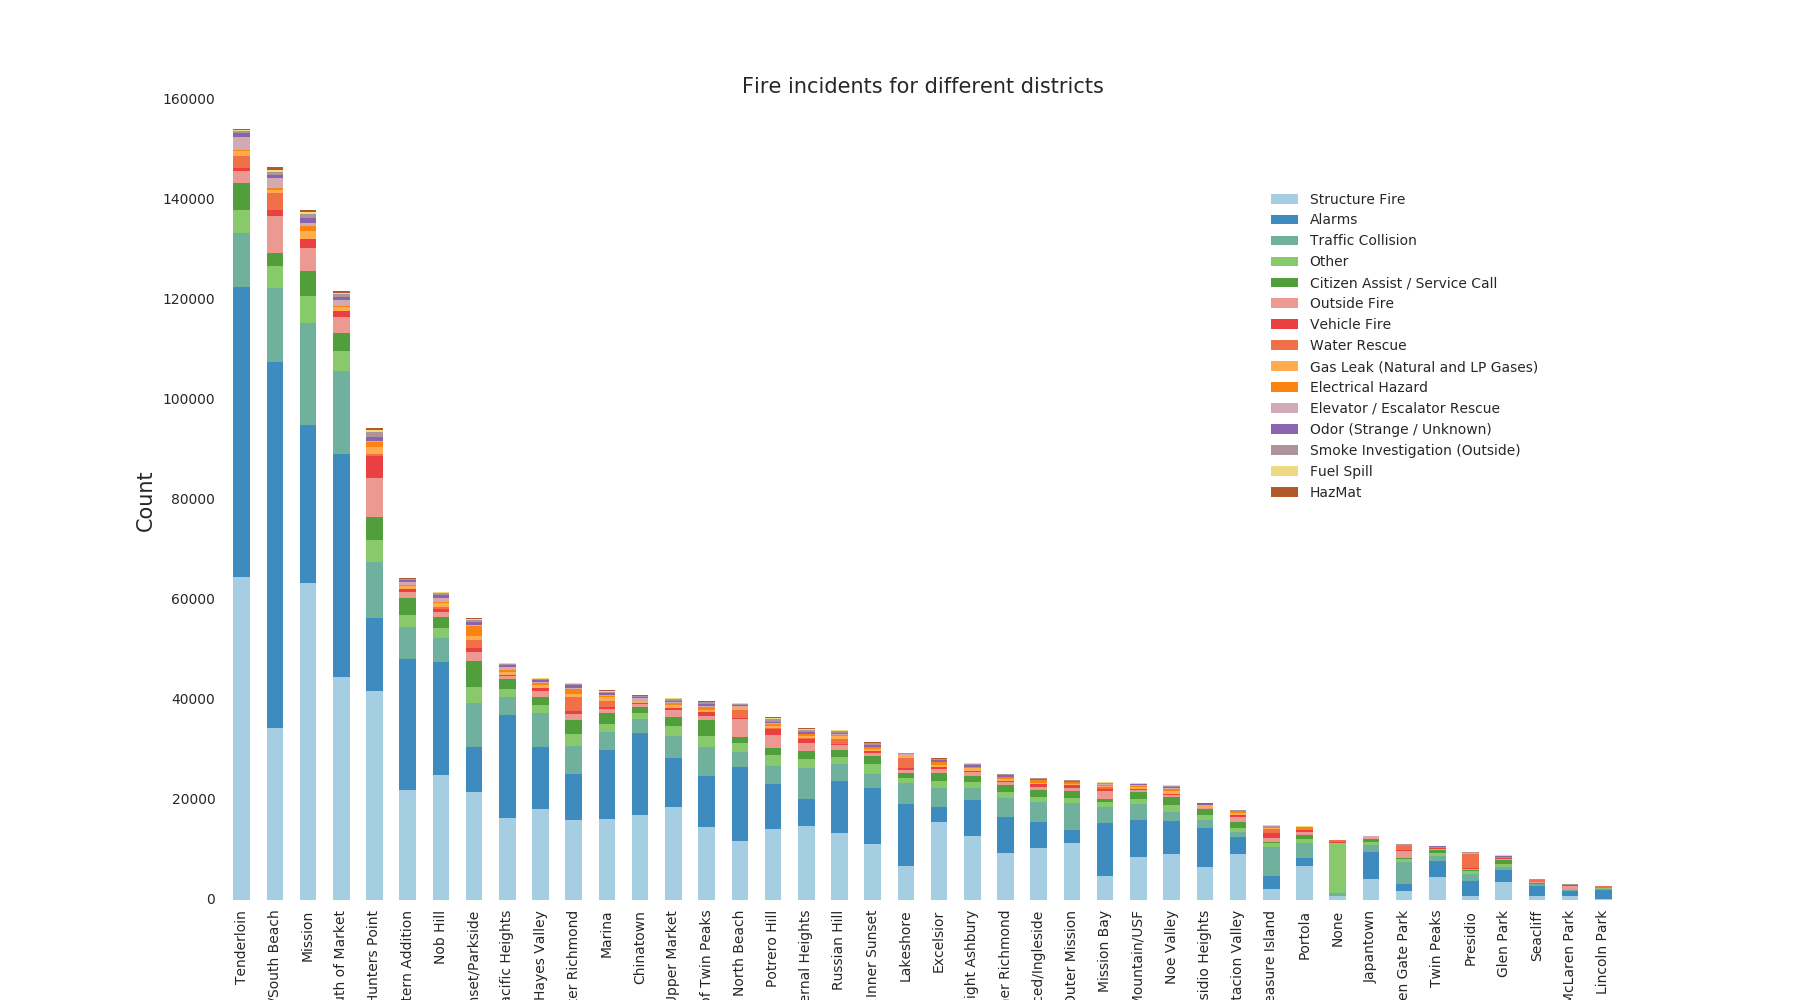

In [21]:
# Visualize incidents of different categories for different district, here we take the top 15 fire emergnecy categories.
fig, ax = plt.subplots(figsize=(18, 10))
df_Pd = df.groupBy('Call Type', 'Neighborhooods - Analysis Boundaries').count()
q2_2 = df_Pd.toPandas()
table = pd.pivot_table(q2_2, values='count', index=['Neighborhooods - Analysis Boundaries'], columns=['Call Type'])
table = table[q1['Call Type'][:15].values]
order = q2['Neighborhooods - Analysis Boundaries'].values
table.loc[order].plot.bar(stacked=True, ax=ax, edgecolor = "none", cmap='Paired').legend(bbox_to_anchor=(0.95, 0.9))
ax.set_title('Fire incidents for different districts', fontsize=15)
ax.set_xlabel('Incident', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
display(fig)

##### 4. The number of fire emergency call in each month of 2015, 2016, 2017, 2018.

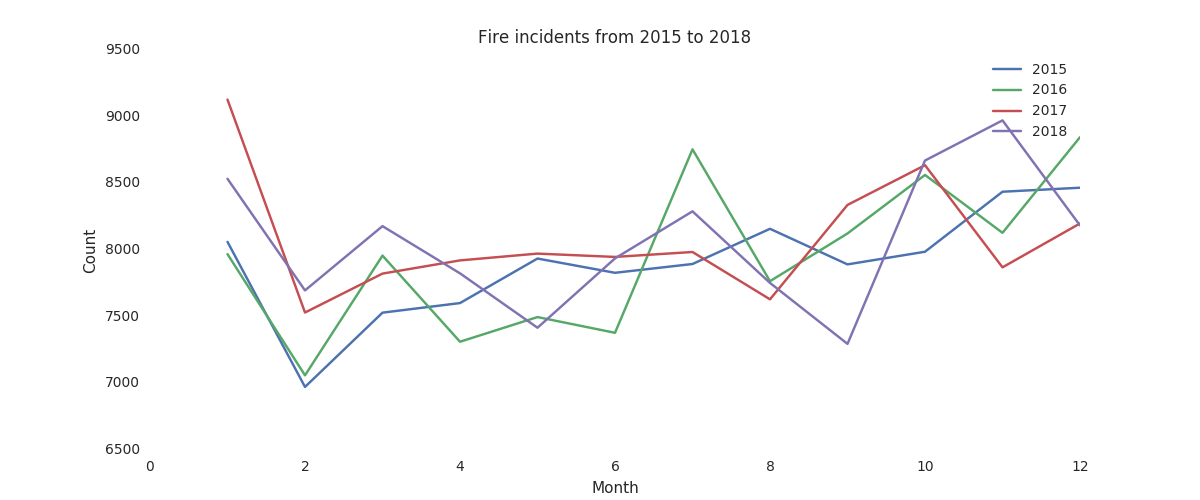

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
for year in ['2015', '2016', '2017', '2018']:
    df_month = df.filter(df['Year'] == year).groupBy('Month').count().orderBy('Month', ascending=True)
    df_month = df_month.toPandas()
    ax.plot(df_month['Month'], df_month['count'],label = year)
    ax.set_title('Fire incidents from 2015 to 2018')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend()
display(fig)

The number of fire-related incidents happens each month from 2015 to 2018 is quite stable. Winter has more fire emergencies than Summer.

##### 5. The number of fire incidents w.r.t the hour in Summer and Winter holiday.

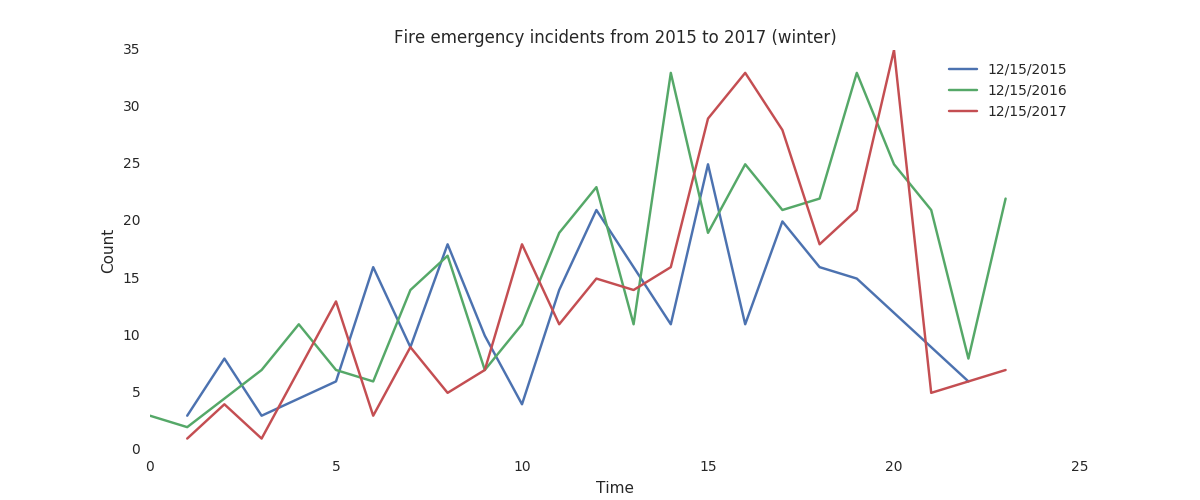

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
for date in ['12/15/2015', '12/15/2016', '12/15/2017']:
    df_hour = df.filter(df['Call Date'] == date).groupBy('Hour').count().orderBy('Hour', ascending=True)
    df_hour = df_hour.toPandas()
    ax.plot(df_hour['Hour'], df_hour['count'], label=date)
    ax.set_title('Fire emergency incidents from 2015 to 2017 (winter)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    ax.legend()
display(fig)

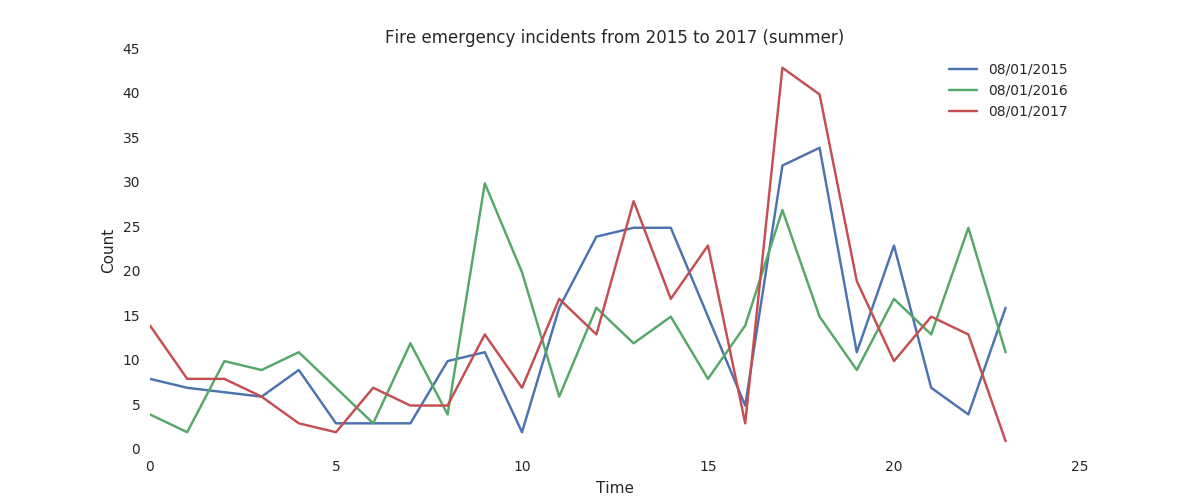

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
for date in ['08/01/2015', '08/01/2016', '08/01/2017']:
    df_hour = df.filter(df['Call Date'] == date).groupBy('Hour').count().orderBy('Hour', ascending=True)
    df_hour = df_hour.toPandas()
    ax.plot(df_hour['Hour'], df_hour['count'], label=date)
    ax.set_title('Fire emergency incidents from 2015 to 2017 (summer)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    ax.legend()
display(fig)

Here we use one day in July and one day in December as example to examine the fire incidents in a day by hours. Overall there are more fire related emergencies in Winter than in Summer. There is a peak in winter between 12 pm to 20pm. Most incidents happened at day time in Summer.

##### 6. Analyze the fire related incidents w.r.t category and time (hour) top-3 districts.

In [30]:
# Top-3 districts with the most fire related emergencies
q2.head(3)

Out[ 22 ]: 
 Neighborhooods - Analysis Boundaries count
0 Tenderloin 155123
1 Financial District/South Beach 148470
2 Mission 139231

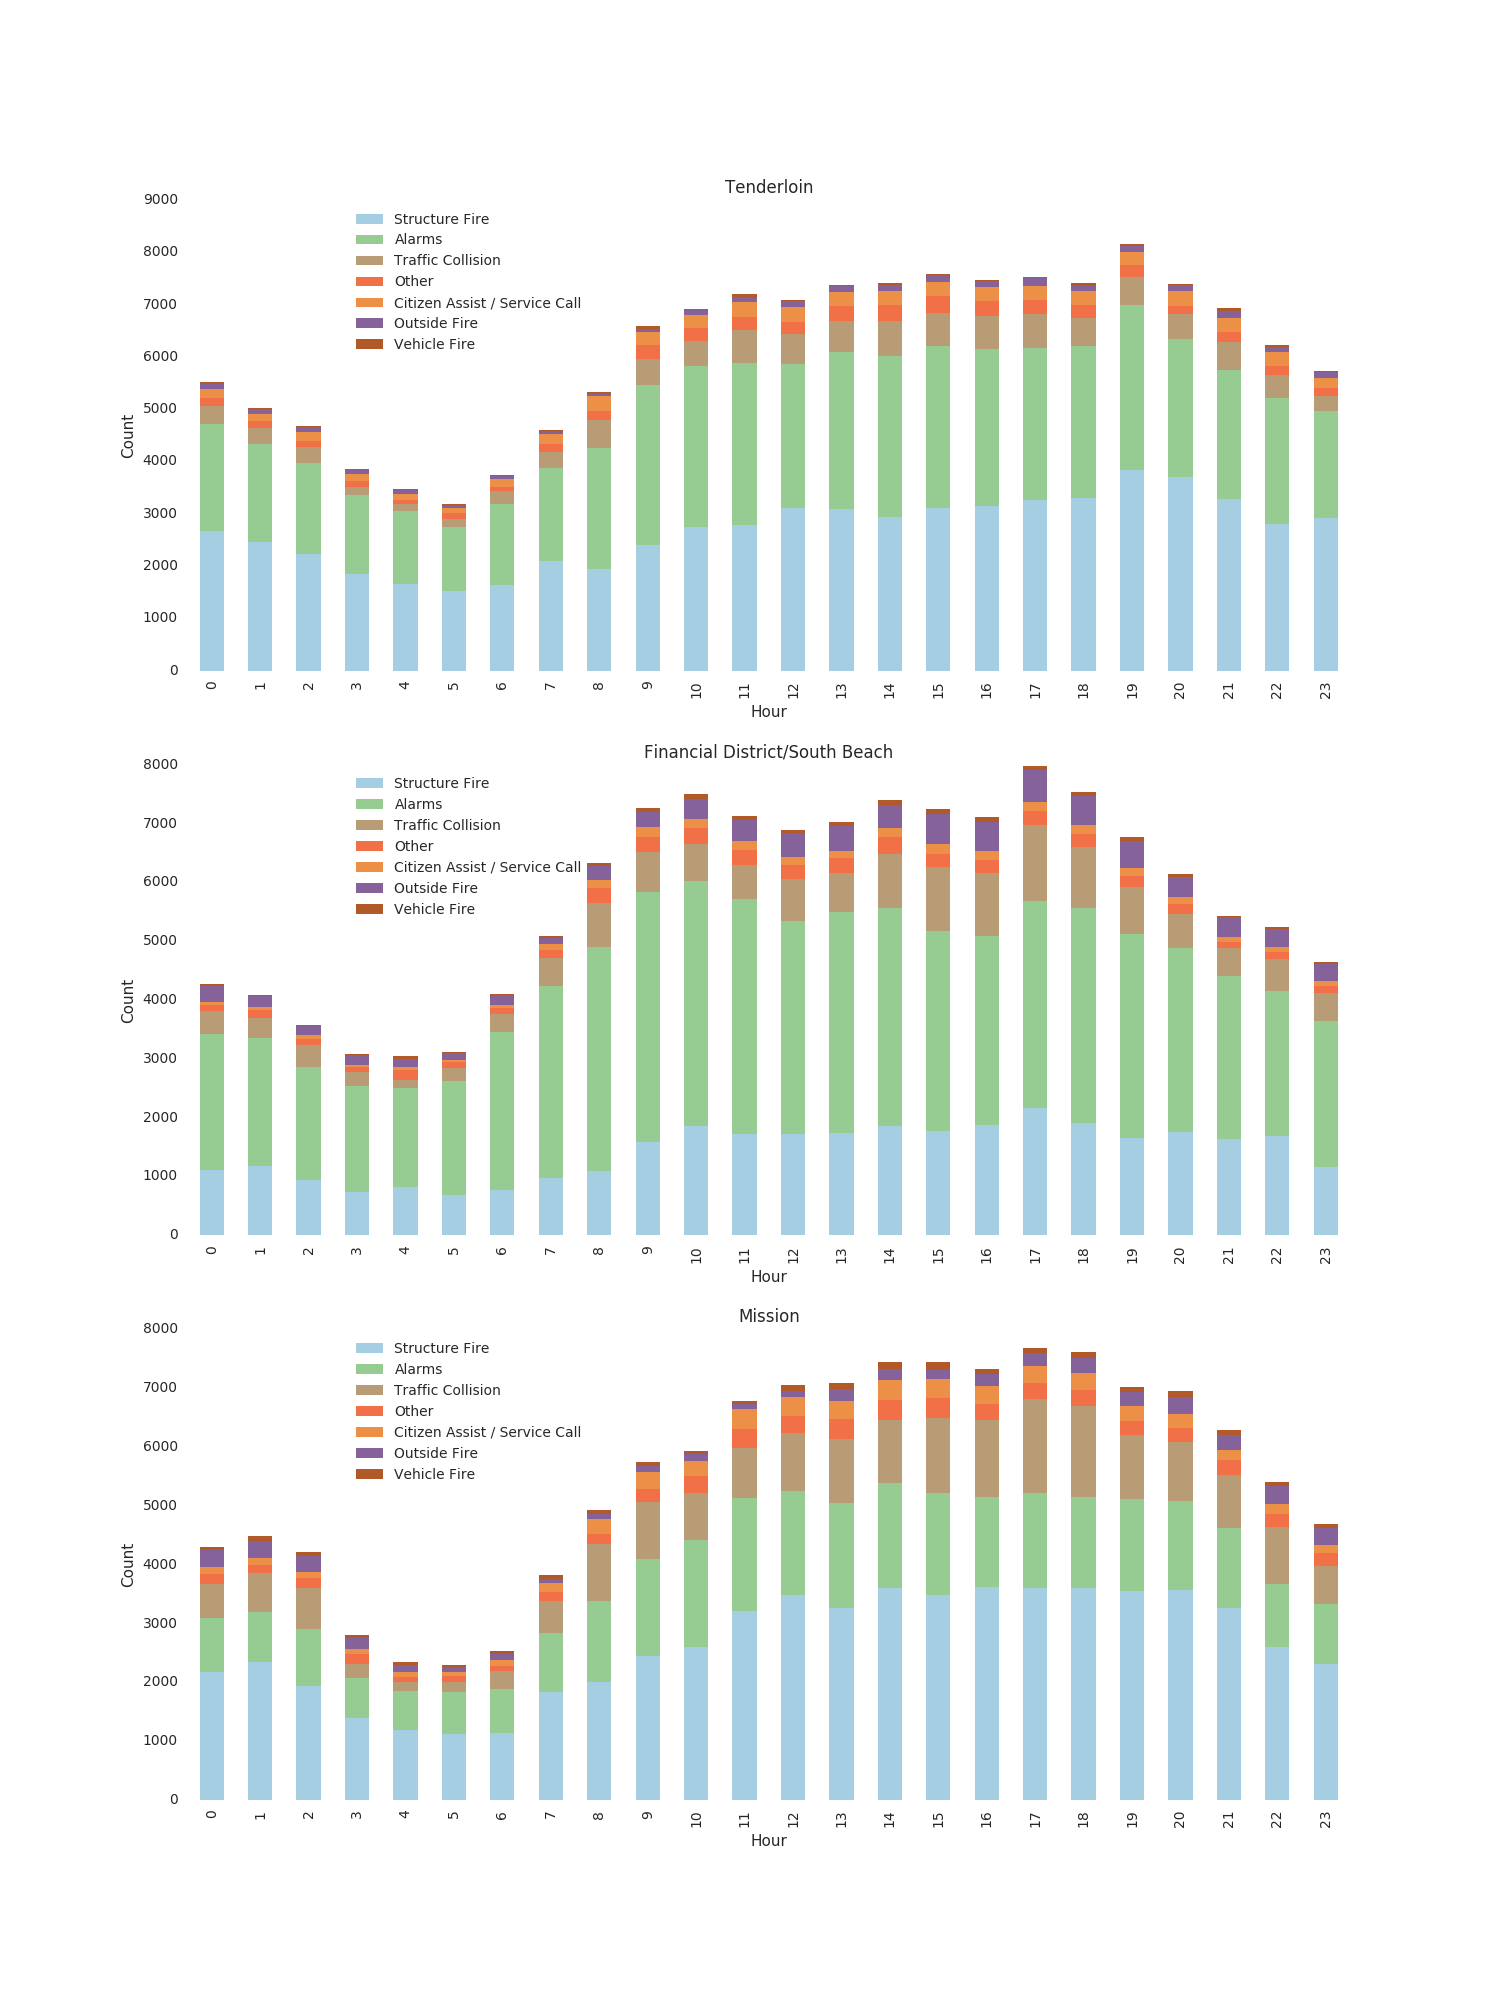

In [31]:
# Visualize fire related event w.r.t category and time (hour) top-3 district
fig, ax = plt.subplots(3, 1, figsize=(15, 20))
area = ['Tenderloin', 'Financial District/South Beach', 'Mission']
for i in range(3):
    df_area = df.filter(df['Neighborhooods - Analysis Boundaries'] == area[i]).groupBy('Call Type', 'Hour').count()
    q6 = df_area.toPandas()
    table = pd.pivot_table(q6, values='count', index=['Hour'], columns=['Call Type'])
    table = table[q1['Call Type'][:7].values]
    table.plot.bar(stacked=True, ax=ax[i], edgecolor = "none", cmap='Paired').legend(bbox_to_anchor=(0.35, 1))
    ax[i].set_title(area[i])
    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Count')
display(fig)

From the plot, we found that most of the fire-related incidents happen in the afternoon, while it is the lowest at 5am. Building fire is a big problem for Tenderloin and Mission, while outside fire, vehicle fire, and alarm are more severe in Financial District/South Beach.

##### 7. Analyze the percentage of different categories of fire related incidents.

In [34]:
df_q7 = df.filter(df['Year'] != 2019).groupBy('Year', 'Call Type').count().orderBy('Call Type', 'Year', ascending=True)
df_q7 = df_q7.toPandas()
sum_year = df_q7.groupby('Year').sum()
df_q7 = df_q7.merge(sum_year, how='left', left_on='Year', right_index=True)
df_q7['percentage'] = df_q7['count_x'] / df_q7['count_y']
df_q7.head(10)

Out[ 24 ]: 
 Year Call Type count_x count_y percentage
0 2001 Administrative 4 85302 0.000047
1 2002 Administrative 9 82899 0.000109
2 2003 Administrative 2 96703 0.000021
3 2004 Administrative 2 89232 0.000022
4 2005 Administrative 93 88879 0.001046
5 2006 Administrative 15 89563 0.000167
6 2007 Administrative 6 87207 0.000069
7 2008 Administrative 29 89050 0.000326
8 2009 Administrative 16 84875 0.000189
9 2010 Administrative 6 87241 0.000069

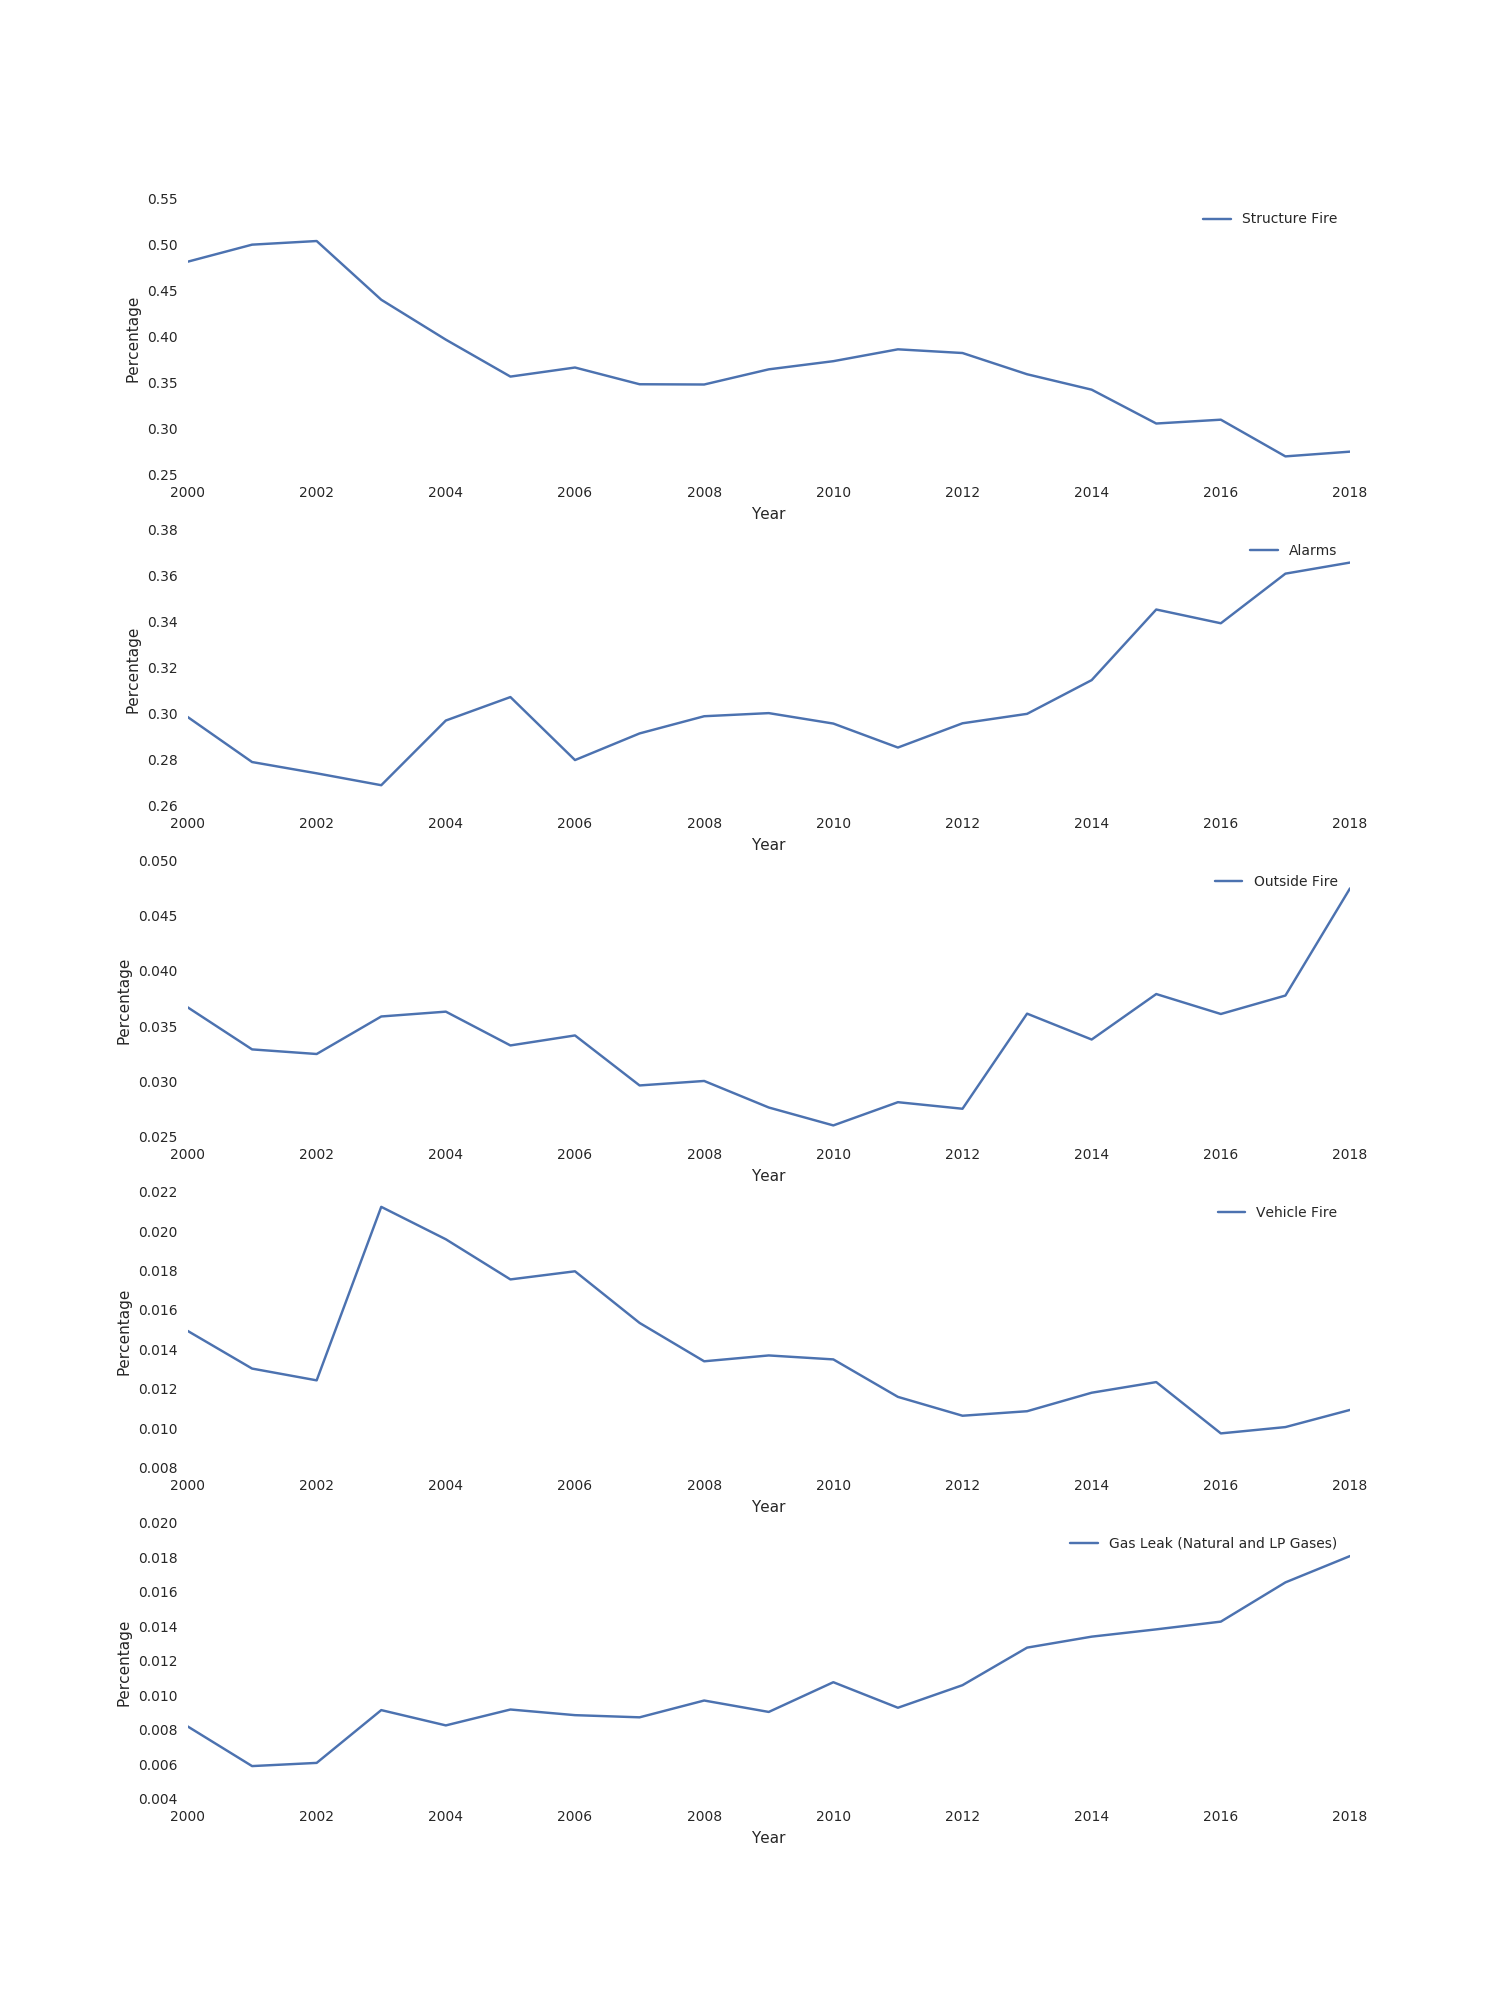

In [35]:
# Visualize the percentage of different fire related incidents over time 
fig, ax = plt.subplots(5, 1, figsize=(15, 20))
j = 0
for category in (q1['Call Type'][i] for i in [0, 1, 5, 6, 8]):
    df_temp = df_q7[df_q7['Call Type'] == category]
    ax[j].plot(df_temp['Year'], df_temp['percentage'],label = category)
    ax[j].set_xlabel('Year')
    ax[j].set_ylabel('Percentage')
    ax[j].legend()
    j += 1
display(fig)

We found that building fires decreased around 20% in 20 years. Vehicle fire decreased around 10%. But Gas leak incidents increased around 10% over years, which may be due to the aging problem of building infrastructures.

#### Apply Spark ML clustering for spatial data analysis

In [38]:
df.show(30)

+-----------+-------+---------------+--------------------+----------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+-------------+---------+-----------+----+-----+----+
Call Number|Unit ID|Incident Number| Call Type| Call Date|Watch Date| Received DtTm| Entry DtTm| Dispatch DtTm| Response DtTm| On Scene DtTm|Transport DtTm|Hospital DtTm|Call Final Disposition| Available DtTm| Address|City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|Number of Alarms|Unit Type|Unit sequence in call dispatch|Fire Prevention District|Supervisor District|Neighborhooods - Analysis Boundaries| Location| RowID| Y| X|Year|Month|hour|
+-----------+-------+---------------+--------------------+----------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+-------------+---------+-----------+----+-----+----+
 001030107| E01| 00030615| Alarms|04/12/2000|04/12/2000|2000-04-12 21:13:47|04/12/2000 09:13:...|04/12/2000 09:14:...|04/12/2000 09:15:...|04/12/2000 09:20:...| null| null| Other|04/12/2000 09:24:...|100 Block of JONE...| SF| 94102| B03| 01|1456| 3| 3| 3| false| null| 1| ENGINE| 3| 3| 6| Tenderloin|37.7825474000421,...|001030107-E01|37.782547| -122.41225|2000| 4| 21|
 001030112| T03| 00030620|Citizen Assist / ...|04/12/2000|04/12/2000|2000-04-12 21:24:27|04/12/2000 09:24:...|04/12/2000 09:25:...|04/12/2000 09:27:...|04/12/2000 09:30:...| null| null| Other|04/12/2000 09:44:...|800 Block of SUTT...| SF| 94109| B01| 03|1463| 3| 3| 3| false| null| 1| TRUCK| 1| 1| 3| Nob Hill|37.7884388430214,...|001030112-T03| 37.78844| -122.41435|2000| 4| 21|
 001030116| E38| 00030624| Electrical Hazard|04/12/2000|04/12/2000|2000-04-12 21:25:55|04/12/2000 09:28:...|04/12/2000 09:28:...|04/12/2000 09:29:...|04/12/2000 09:31:...| null| null| Other|04/12/2000 09:39:...|CALIFORNIA ST/VAN...| SF| 94109| B04| 38|3155| 3| 3| 3| false| null| 1| ENGINE| 1| 4| 2| Nob Hill|37.7903696585646,...|001030116-E38| 37.79037| -122.42233|2000| 4| 21|
 001030117| E15| 00030626|Odor (Strange / U...|04/12/2000|04/12/2000|2000-04-12 21:27:55|04/12/2000 09:28:...|04/12/2000 09:30:...|04/12/2000 09:31:...|04/12/2000 09:34:...| null| null| Other|04/12/2000 09:38:...|2100 Block of ALE...| SF| 94112| B09| 15|8331| 3| 3| 3| false| null| 1| ENGINE| 1| 9| 11| Outer Mission|37.7183153380753,...|001030117-E15|37.718315| -122.44192|2000| 4| 21|
 001030120| E13| 00030627| Alarms|04/12/2000|04/12/2000|2000-04-12 21:30:54|04/12/2000 09:30:...|04/12/2000 09:31:...|04/12/2000 09:34:...|04/12/2000 09:34:...| null| null| Other|04/12/2000 09:50:...|500 Block of COMM...| SF| 94111| B01| 13|1166| 3| 3| 3| false| null| 1| ENGINE| 1| 1| 3| Chinatown|37.7942116655012,...|001030120-E13|37.794212| -122.40264|2000| 4| 21|
 001030128| E05| 00030636| Alarms|04/12/2000|04/12/2000|2000-04-12 21:45:28|04/12/2000 09:46:...|04/12/2000 09:46:...|04/12/2000 09:48:...|04/12/2000 09:49:...| null| null| Other|04/12/2000 10:19:...|1400 Block of STE...| SF| 94115| B04| 05|3623| 3| 3| 3| false| null| 1| ENGINE| 1| 5| 5| Western Addition|37.7826256736324,...|001030128-E05|37.782627| -122.43419|2000| 4| 2

In [39]:
q8_result = df.groupBy('X', 'Y').count()
q8 = q8_result.toPandas()

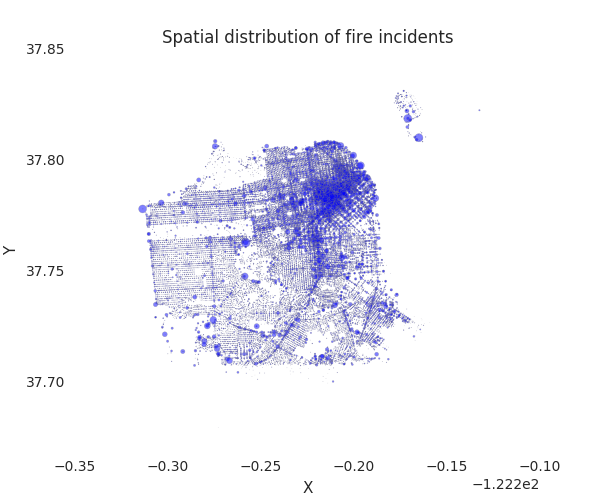

In [40]:
# Visualize the spatial distribution of fire related incidents
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(q8['X'], q8['Y'], s=q8['count']/100, alpha=0.5, edgecolors='grey')
ax.set_title('Spatial distribution of fire incidents')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylim([37.67, 37.85])
display(fig)

The dot size imply the number of fire related incidents in that place, we can see that the rate is very high in the northeast of SF where also has most population.

In [42]:
# Perfrom clustering analysis based on the number of top 5 fire incident categories at different location.
df_cluster = df.groupBy('X', 'Y').pivot('Call Type').count()
df_cluster = df_cluster.na.fill(0)

In [43]:
FEATURES_COL = ['Structure Fire', 'Alarms', 'Outside Fire', 'Vehicle Fire', 'Gas Leak (Natural and LP Gases)']

In [44]:
df_cluster

Out[ 31 ]: DataFrame[X: float, Y: float, Administrative: bigint, Aircraft Emergency: bigint, Alarms: bigint, Assist Police: bigint, Citizen Assist / Service Call: bigint, Confined Space / Structure Collapse: bigint, Electrical Hazard: bigint, Elevator / Escalator Rescue: bigint, Explosion: bigint, Extrication / Entrapped (Machinery, Vehicle): bigint, Fuel Spill: bigint, Gas Leak (Natural and LP Gases): bigint, HazMat: bigint, High Angle Rescue: bigint, Industrial Accidents: bigint, Lightning Strike (Investigation): bigint, Marine Fire: bigint, Mutual Aid / Assist Outside Agency: bigint, Odor (Strange / Unknown): bigint, Oil Spill: bigint, Other: bigint, Outside Fire: bigint, Smoke Investigation (Outside): bigint, Structure Fire: bigint, Suspicious Package: bigint, Traffic Collision: bigint, Train / Rail Fire: bigint, Train / Rail Incident: bigint, Vehicle Fire: bigint, Water Rescue: bigint, Watercraft in Distress: bigint]

In [45]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df_cluster).select('X', 'Y', 'features')
df_kmeans.show(20)

+-----------+---------+--------------------+
 X| Y| features|
+-----------+---------+--------------------+
 -122.40341|37.727016|[136.0,12.0,2.0,0...|
 -122.43595|37.795174|(5,[0,1],[25.0,37...|
-122.403305|37.774975|[36.0,3.0,2.0,0.0...|
 -122.45778|37.740746|(5,[0,1],[24.0,3.0])|
 -122.46428|37.781017|[11.0,0.0,21.0,3....|
 -122.41459| 37.78511|[150.0,476.0,5.0,...|
 -122.41486|37.782635|[263.0,770.0,3.0,...|
-122.467514|37.765877| (5,[1,2],[3.0,2.0])|
-122.432236|37.766674| (5,[0],[14.0])|
 -122.43653| 37.76398| (5,[2],[15.0])|
-122.415794|37.804104| (5,[0],[13.0])|
 -122.4047| 37.77064|(5,[0,1],[10.0,27...|
-122.448135|37.767944|[32.0,14.0,1.0,2....|
-122.455795|37.774673| (5,[1,2],[2.0,2.0])|
 -122.49545|37.780563| (5,[1,4],[3.0,1.0])|
 -122.48747| 37.73696| (5,[],[])|
 -122.47973|37.738197|(5,[0,3],[19.0,2.0])|
 -122.44162| 37.71726| (5,[],[])|
 -122.42937| 37.76604|[29.0,4.0,2.0,1.0...|
-122.432846|37.796524|(5,[0,1],[31.0,37...|
+-----------+---------+--------------------+
only showing top 20 rows

In [46]:
# Trains a k-means model
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [47]:
transformed = model.transform(df_kmeans).select('X', 'Y', 'prediction')
rows = transformed.collect()
print(rows[:5])

[Row(X=-122.40341186523438, Y=37.72701644897461, prediction=0), Row(X=-122.43595123291016, Y=37.79517364501953, prediction=0), Row(X=-122.40330505371094, Y=37.77497482299805, prediction=0), Row(X=-122.45777893066406, Y=37.740745544433594, prediction=0), Row(X=-122.46427917480469, Y=37.7810173034668, prediction=0)]

In [48]:
# Clustering result
df_pred = sqlContext.createDataFrame(rows)
df_pred.show(20)

+-------------------+------------------+----------+
 X| Y|prediction|
+-------------------+------------------+----------+
-122.40341186523438| 37.72701644897461| 0|
-122.43595123291016| 37.79517364501953| 0|
-122.40330505371094| 37.77497482299805| 0|
-122.45777893066406|37.740745544433594| 0|
-122.46427917480469| 37.7810173034668| 0|
-122.41458892822266| 37.78511047363281| 4|
-122.41486358642578| 37.78263473510742| 3|
-122.46751403808594| 37.76587677001953| 0|
-122.43223571777344| 37.76667404174805| 0|
-122.43653106689453|37.763980865478516| 0|
 -122.4157943725586| 37.80410385131836| 0|
-122.40470123291016| 37.7706413269043| 0|
-122.44813537597656| 37.7679443359375| 0|
-122.45579528808594| 37.77467346191406| 0|
-122.49545288085938| 37.78056335449219| 0|
-122.48747253417969|37.736961364746094| 0|
-122.47972869873047|37.738197326660156| 0|
-122.44161987304688| 37.71725845336914| 0|
-122.42936706542969| 37.76604080200195| 0|
-122.43284606933594| 37.79652404785156| 0|
+-------------------+------------------+----------+
only showing top 20 rows

In [49]:
# Merge clustering results with fire events count
df_pred = df_pred.toPandas()
df_pred = df_pred.merge(q8, on=['X','Y'])
df_pred.head(20)

Out[ 36 ]: 
 X Y prediction count
0 -122.403412 37.727016 0 174
1 -122.435951 37.795174 0 80
2 -122.403305 37.774975 0 44
3 -122.457779 37.740746 0 38
4 -122.464279 37.781017 0 193
5 -122.414589 37.785110 4 687
6 -122.414864 37.782635 3 1175
7 -122.467514 37.765877 0 67
8 -122.432236 37.766674 0 16
9 -122.436531 37.763981 0 17
10 -122.415794 37.804104 0 15
11 -122.404701 37.770641 0 52
12 -122.448135 37.767944 0 70
13 -122.455795 37.774673 0 32
14 -122.495453 37.780563 0 7
15 -122.487473 37.736961 0 3
16 -122.479729 37.738197 0 22
17 -122.441620 37.717258 0 4
18 -122.429367 37.766041 0 47
19 -122.432846 37.796524 0 85

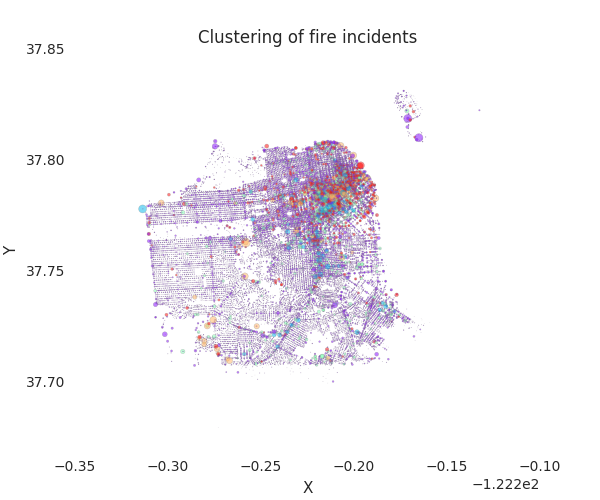

In [50]:
# Visulize clustering results (5 clusters)
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(df_pred['X'], df_pred['Y'], s=df_pred['count']/100, c=df_pred['prediction'], cmap='rainbow', alpha=0.5, edgecolors='grey')
ax.set_title('Clustering of fire incidents')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylim([37.67, 37.85])
display(fig)

#### Time series analysis 
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction

In [52]:
df_ts = df.groupBy('Call Date', 'Call Type').count().orderBy('Call Date', ascending=True)
df_ts = df_ts.toPandas()

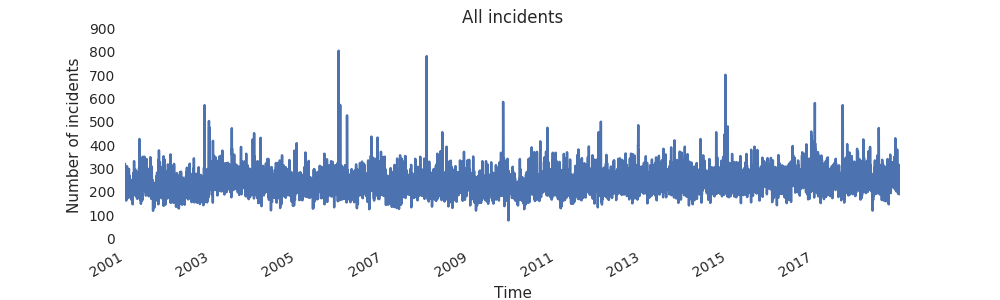

In [53]:
# Visualize time series of all incidents
df_all = df_ts.groupby('Call Date').sum()
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all['2001-1' : '2018-12']
fig, ax = plt.subplots(figsize=(10, 3))
df_all['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of incidents')
ax.set_title('All incidents')
display(fig)

In [54]:
FEATURES_COL = ['Structure Fire', 'Alarms', 'Outside Fire', 'Vehicle Fire', 'Gas Leak (Natural and LP Gases)']

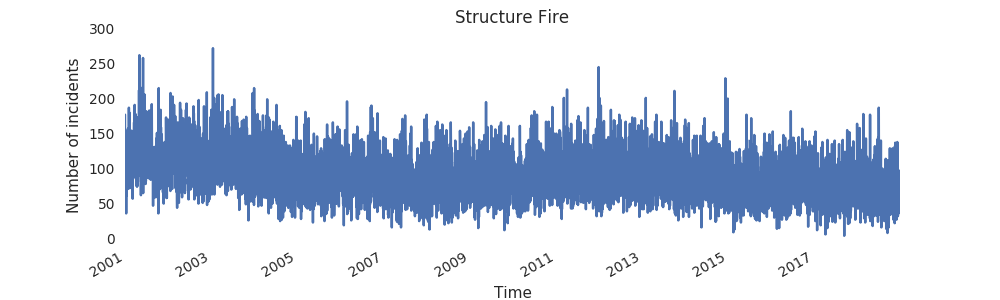

In [55]:
# Visualize time series of 'Structure Fire
df_Fire = df_ts[df_ts['Call Type'] == 'Structure Fire']
df_Fire.index = pd.to_datetime(df_Fire['Call Date'])
df_Fire = df_Fire['2001-1' : '2018-12']
fig, ax = plt.subplots(figsize=(10, 3))
df_Fire['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of incidents')
ax.set_title('Structure Fire')
display(fig)

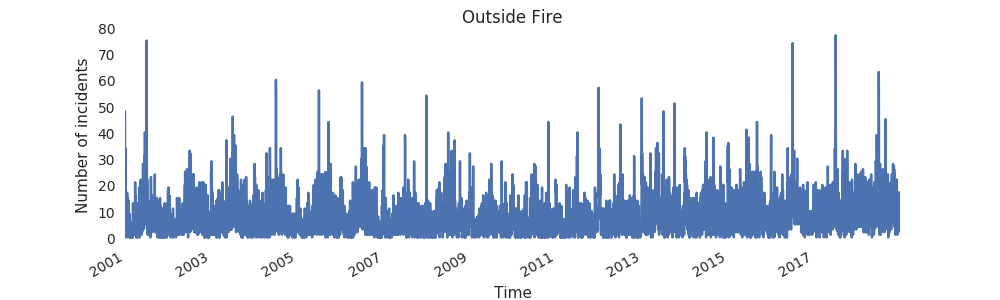

In [56]:
# Visualize time series of Outside Fire
df_Outside_Fire = df_ts[df_ts['Call Type'] == 'Outside Fire']
df_Outside_Fire.index = pd.to_datetime(df_Outside_Fire['Call Date'])
df_Outside_Fire = df_Outside_Fire['2001-1' : '2018-12']
fig, ax = plt.subplots(figsize=(10, 3))
df_Outside_Fire['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of incidents')
ax.set_title('Outside Fire')
display(fig)

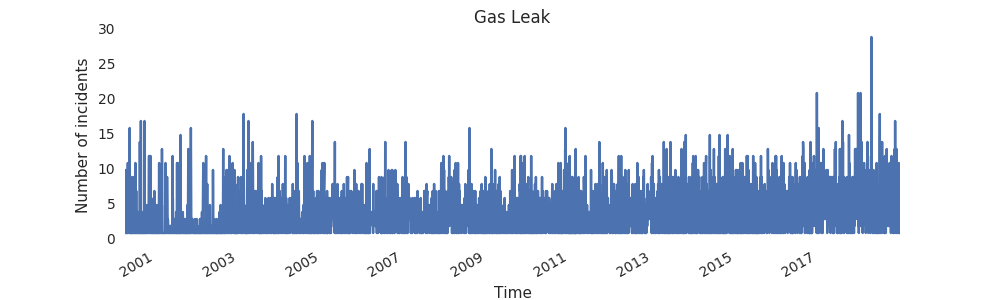

In [57]:
# Visualize time series of Gas Leak
df_Gas = df_ts[df_ts['Call Type'] == 'Gas Leak (Natural and LP Gases)']
df_Gas.index = pd.to_datetime(df_Gas['Call Date'])
df_Gas = df_Gas['2000-1' : '2018-12']
fig, ax = plt.subplots(figsize=(10, 3))
df_Gas['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of incidents')
ax.set_title('Gas Leak')
display(fig)

##### Build ARIMA to predict Gas Leak events.

In [59]:
# Groups the data in buckets by start of the month
df_month = df_Gas.resample('MS').sum()

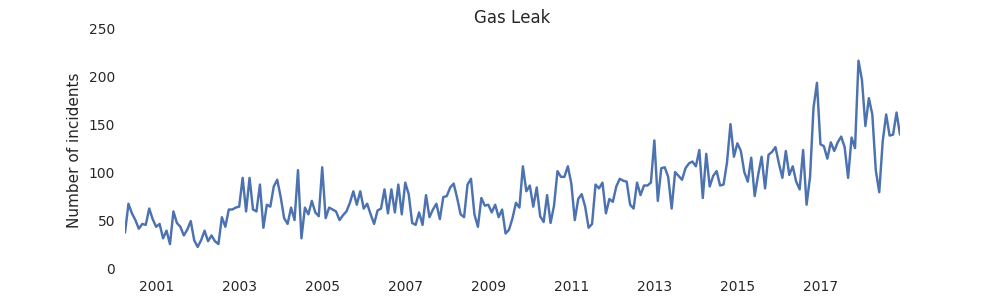

In [60]:
fig, ax = plt.subplots(figsize=(10, 3))
df_month['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of incidents')
ax.set_title('Gas Leak')
display(fig)

Intuitively, the data is not stationary. We will analyze further.

In [62]:
#  Run augmented Dickey-Fuller test to check the stationarity
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
testStationarity(df_month['count'])

Out[ 46 ]: 
Test Statistic 0.309224
p-value 0.977764
#Lags Used 13.000000
Number of Observations Used 211.000000
Critical Value (10%) -2.574124
Critical Value (5%) -2.875337
Critical Value (1%) -3.461727
dtype: float64

p-value larger than 0.05. Can't reject the hypothesis. The time series is not stationary.

##### Plot ACF and PACF

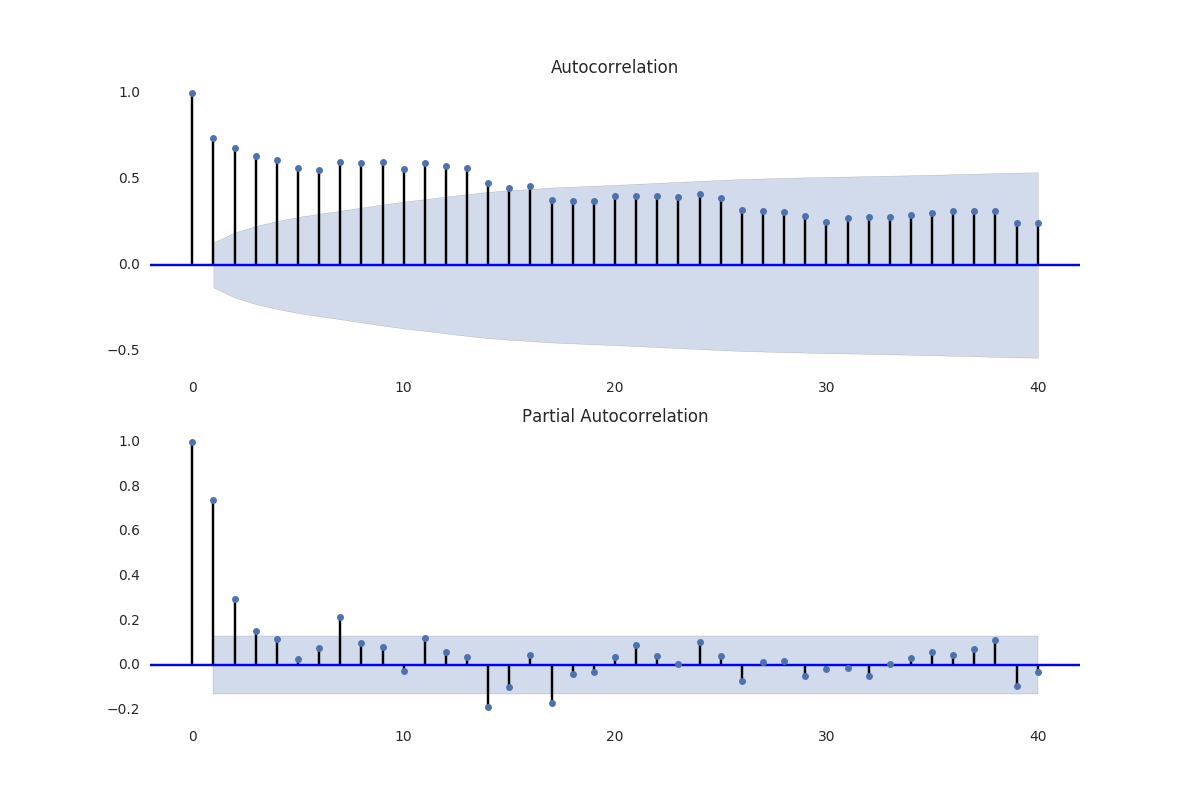

In [65]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_month['count'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_month['count'], lags=40, ax=ax2)
display(fig)

##### Time series decomposition

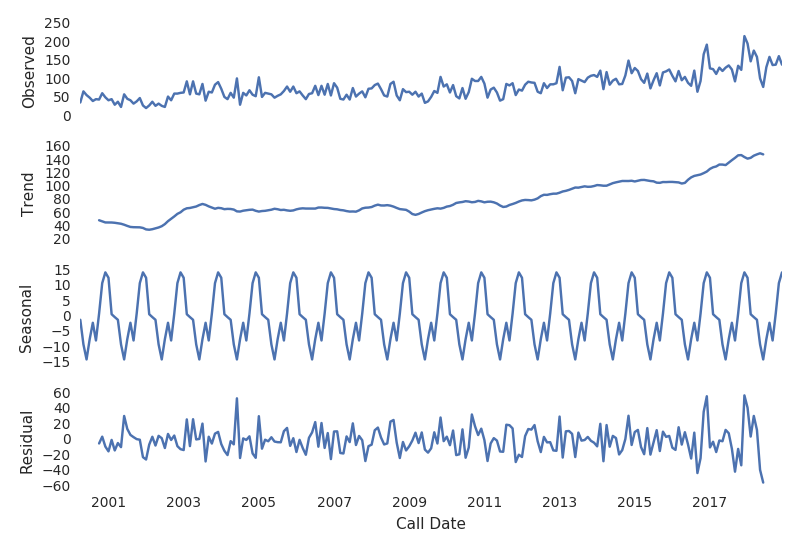

In [67]:
fig = plt.figure(figsize=(20,20))  
decomposition = seasonal_decompose(df_month, freq=12)  
fig = decomposition.plot()  
display(plt.show())

From the ACF and PCF plot, and the seasonality after decomposition, we further confirmed that the time series is not stationary and there is also a 12 month seasonal period in the time series. We will use a seasonal ARIMA model for prediction.

We will use grid search to find the best hyper parameter for the model, below we iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model.

##### Seasonal ARIMA model

In [70]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [71]:
warnings.filterwarnings("ignore")
# split train and test data
train, test = df_month[:-12], df_month[-12:]
res = float('inf')
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if res > results.aic:
              best_param = param + param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2184.4693430759353
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1964.2626250206279
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1716.1593432664263
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1597.499380944571
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1651.7795870645023
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1487.7558924270675
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1862.526251207609
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1778.6831649013016
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1681.2615490580597
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1725.621401131802
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1718.0601280275641
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1599.4698998928009
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1721.3917497877937
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1624.2286722670215
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:1501.082168275242
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:1711.5631960076646
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:1690.06907564173
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:1678.3181755067856
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:1611.8697854721222
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:1613.4950451674772
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:1601.3476894806727
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:1551.61356414085
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:1511.1471690494895
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:1503.926746302659
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2285.5787281225594
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2079.250919433348
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:1909.0218885400222
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1842.9603914290633
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1703.4490936935172
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:1586.678582711971
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:1926.9032259298176
ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:1642.9890093950212
ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:1481.6105122971128
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1863.4810251025701
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1767.395923251635
ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:1672.2989146945672
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1722.678695688559
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1705.1846498759646
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:1588.677880052431
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:1723.2694074850037
ARIMA(0, 0, 1)x(1, 2, 1, 12)12 - AIC:1614.6487428656735
ARIMA(0, 0, 1)x(1, 2, 2, 12)12 - AIC:1483.6399736064013
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:1712.250513633854
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:1716.5098361061011
ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:1669.3250149149967
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:1609.5849972369656
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:1611.3778561518745
ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:1589.1779544171206
ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:1553.4547366194038
ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:1512.6920091296577
ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:1485.6084954501973
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:2161.1425673043705
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:1987.8962961443415
ARIMA(0, 0, 2)x(0, 0, 2, 12)12 - AIC:1838.4737360129197
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:1821.7672868961154
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:1680.4344307180088
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:1571.1387877884076
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:1907.1508873941852
ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:1626.1916889538265
ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:1467.1824810196688
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:1851.3972342674988
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:1754.1598965442004
ARIMA(0, 0, 2)x(1, 0, 2, 12)12 - AIC:1662.5130646171058
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:1710.822556636981
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1683.6108332645367
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:1572.6455838424342
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:1714.086608434186
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:1598.5522304856559
ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:1469.1764623889117
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:1705.5283898681814
ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:1709.951889648038
ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:1656.

In [72]:
# Best parameter p,d,q,P,D,Q,S that have smallest AIC
print (best_param)

(2, 2, 2, 2, 2, 2, 12)

In [73]:
# Train the model
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

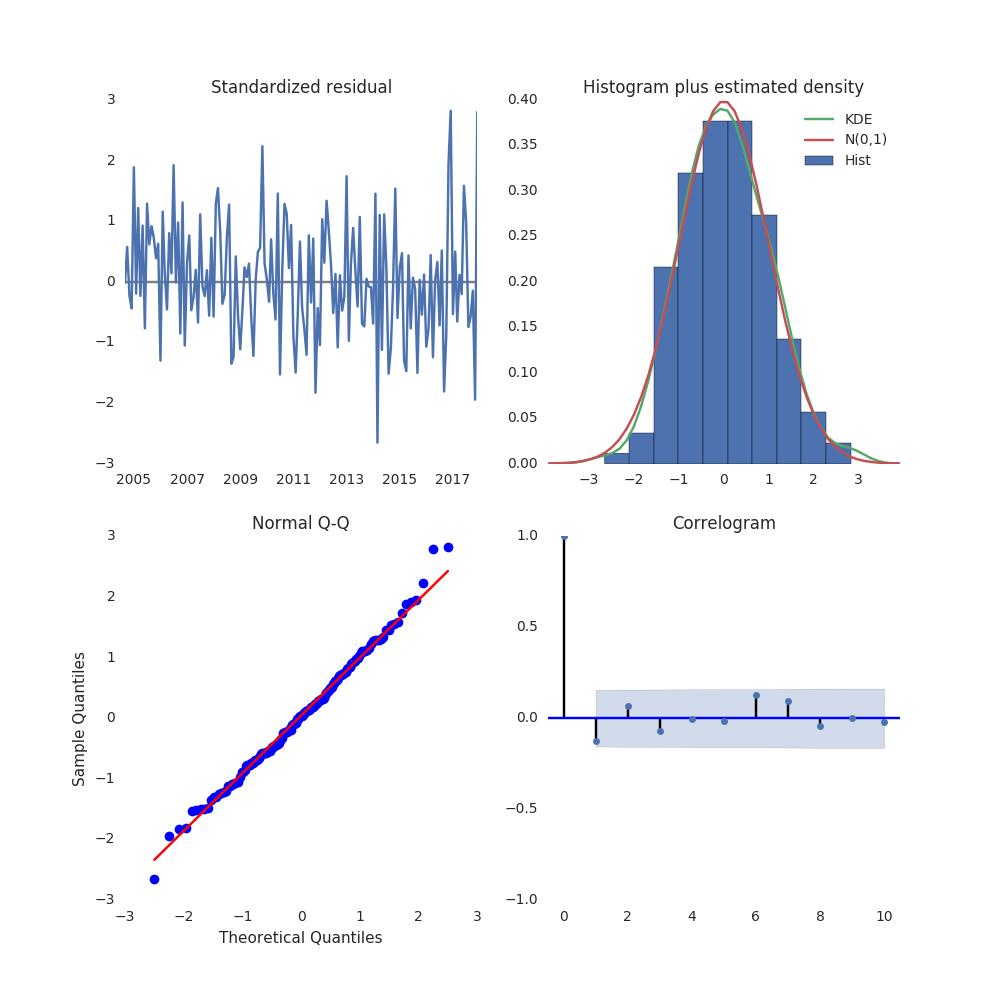

In [74]:
# Check the prediction results using diagnostic plots for standardized residuals
results.plot_diagnostics(figsize=(10, 10))
display(plt.show())

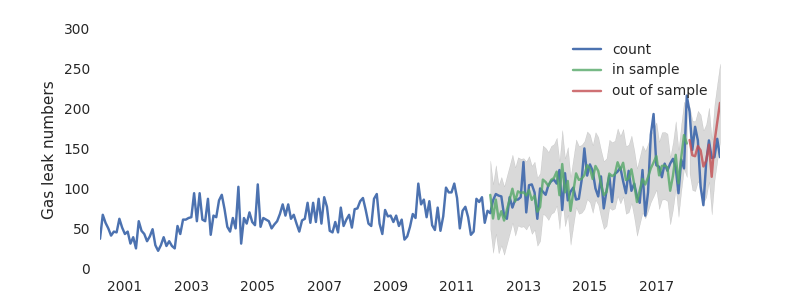

In [75]:
# Visualize the prediction
pred = results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_ci = pred.conf_int()
fore = results.get_forecast(steps=12)
fore_ci = fore.conf_int() 

fig, ax = plt.subplots(figsize=(8, 3))
df_month.plot(ax=ax)
pred.predicted_mean.plot(ax=ax, label='in sample', alpha=0.8)
fore.predicted_mean.plot(ax=ax, label='out of sample', alpha=0.8)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.15)
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=0.15)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Gas leak numbers')
display(plt.show())